In [6]:
import pickle
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import highway_env
import pyvirtualdisplay
import os
from IPython.display import HTML, display
from torch.utils.tensorboard import SummaryWriter
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo


In [120]:
### Fonctions de visualisation ###

from pyvirtualdisplay import Display
import os
if os.name != 'nt':
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1024, 768))
    display.start()

from matplotlib import pyplot as plt, animation
%matplotlib inline
from IPython import display

def create_anim(frames, dpi, fps):
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    def setup():
        plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, init_func=setup, frames=len(frames), interval=fps)
    return anim

def display_anim(frames, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    return anim.to_jshtml()

def save_anim(frames, filename, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    # FORCER LE BACKEND FFMPEG (nécessite ffmpeg installé sur votre système)
    writer = FFMpegWriter(fps=fps)
    anim.save(filename, writer=writer, dpi=dpi)


class trigger:
    def __init__(self):
        self._trigger = True

    def __call__(self, e):
        return self._trigger

    def set(self, t):
        self._trigger = t

In [121]:
# Load environment configuration
with open("config_part1.pkl", "rb") as f:
    config = pickle.load(f)

env = gym.make('highway-v0', render_mode="rgb_array")
env.unwrapped.configure(config)
raw_env = env.unwrapped
def make_env(render_mode='rgb_array'):
    # crée l'env avec render_mode
    env = gym.make("highway-fast-v0", config=config, render_mode=render_mode)
    # enregistre automatiquement les stats (reward, longueur, success…)
    env = RecordEpisodeStatistics(env)
    # filme tous les épisodes dans videos/ avec préfixe "episode"
    env = RecordVideo(
        env,
        video_folder="videos/",
        episode_trigger=lambda episode_id: episode_id % 10 == 0,
        name_prefix="episode"
    )
    return env
idle_idx = env.unwrapped.action_type.actions_indexes["IDLE"]

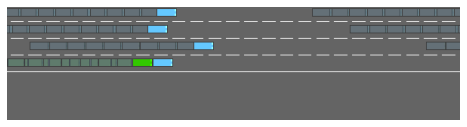

In [ ]:
# Boucle d'extraction des frames
### Code de vérification de l'animation ###
frames = []
# gym.reset() renvoie (obs, info)
reset_ret = env.reset()
obs, info = reset_ret if isinstance(reset_ret, tuple) else (reset_ret, {})

done = False
truncated = False

for _ in range(150):
    frame = env.render()           
    frames.append(frame)

    step_ret = env.step(idle_idx)
    if len(step_ret) == 5:
        obs, reward, done, truncated, info = step_ret
    else:
        obs, reward, done, info = step_ret

    if done or truncated:
        break

# 5. Nettoyage
env.close()

# 6. Affichage de l'animation dans le notebook
HTML(display_anim(frames, dpi=72, fps=50))

In [123]:
# Set seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Hyperparameters
gamma = 0.99
batch_size = 64
buffer_capacity = 10000
update_target_every = 50  # steps before target network update
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay = 1e-4       # decrease per step
learning_rate = 1e-3
num_episodes = 500
max_steps = int(config.get("duration", 60) * config.get("policy_frequency", 1))

# Définition du writer pour TensorBoard
writer = SummaryWriter(log_dir='highway_dqn/')



### Définition des classes

In [124]:
# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    def push(self, state, action, reward, done, next_state):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, done, next_state)
        self.position = (self.position + 1) % self.capacity
    def sample(self, batch_size):
        return random.sample(self.memory, k=batch_size)
    def __len__(self):
        return len(self.memory)

# Neural Network for Q-values
class Net(nn.Module):
    def __init__(self, obs_dim, hidden_dim, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions)
        )
    def forward(self, x):
        return self.net(x)

# DQN Agent
class DQNAgent:
    def __init__(self, obs_shape, n_actions, writer = None):
        self.obs_dim = int(np.prod(obs_shape))
        self.n_actions = n_actions
        self.q_net = Net(self.obs_dim, 128, n_actions)
        self.target_net = Net(self.obs_dim, 128, n_actions)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.buffer = ReplayBuffer(buffer_capacity)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.steps_done = 0
        self.epsilon = epsilon_start
        self.losses = []
        self.writer = writer # stockage du writer pour tensorboard

    def get_action(self, state, use_epsilon=True):
        if use_epsilon and random.random() < self.epsilon:
            return env.action_space.sample()
        state_v = torch.tensor(state, dtype=torch.float32).view(1, -1)
        q_vals = self.q_net(state_v)
        return int(torch.argmax(q_vals, dim=1).item())

    def append_and_learn(self, state, action, reward, done, next_state):
        self.buffer.push(state, action, reward, done, next_state)
        if len(self.buffer) < batch_size:
            return None
        batch = self.buffer.sample(batch_size)
        states, actions, rewards, dones, next_states = zip(*batch)
        states_arr = np.stack(states).astype(np.float32)
        next_states_arr = np.stack(next_states).astype(np.float32)
        states_v = torch.from_numpy(states_arr).view(batch_size, -1)
        next_states_v = torch.from_numpy(next_states_arr).view(batch_size, -1)
        actions_v = torch.tensor(actions, dtype=torch.int64).view(batch_size, 1)
        rewards_v = torch.tensor(rewards, dtype=torch.float32)
        dones_v = torch.tensor(dones, dtype=torch.float32)
        q_values = self.q_net(states_v).gather(1, actions_v).squeeze(1)
        next_q_values = self.target_net(next_states_v).max(1)[0]
        expected_q = rewards_v + gamma * next_q_values * (1 - dones_v)
        loss = nn.MSELoss()(q_values, expected_q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.losses.append(loss.item())
        # ─── Logging conditionnel dans TensorBoard ───
        if self.writer is not None:
            self.writer.add_scalar("train/loss", loss.item(), self.steps_done)
        if self.steps_done % update_target_every == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())
        self.epsilon = max(epsilon_end, self.epsilon - epsilon_decay)
        self.steps_done += 1
        return loss.item()


In [125]:
# Training function
def train_agent(agent, episodes):
    rewards = []
    for ep in range(episodes):
        state, _ = env.reset()
        state = np.array(state, dtype=np.float32)
        total_reward = 0.0
        for t in range(max_steps):
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)
            done = terminated or truncated
            agent.append_and_learn(state, action, reward, done, next_state)
            state = next_state
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
        print(f"Episode {ep+1}/{episodes} - Reward: {total_reward:.2f} - Epsilon: {agent.epsilon:.3f}")
                # ─── LOG DANS TENSORBOARD ───
        writer.add_scalar("rollout/ep_rew_mean", total_reward, ep)
        writer.add_scalar("rollout/exploration_rate", agent.epsilon, ep)
    return rewards


In [126]:
def load_and_evaluate(model_path,
                      episodes=5,
                      max_steps=max_steps,
                      fps=30,
                      video_path='highway_dqn/eval.mp4'
                      ):
    # --- 1. Création de l'env d'évaluation en mode rgb_array
    eval_env = make_env(render_mode='rgb_array')

    # --- 2. Instanciation et chargement de l'agent
    sample_obs, _ = eval_env.reset()
    obs_shape = np.array(sample_obs, dtype=np.float32).shape
    eval_agent = DQNAgent(obs_shape, eval_env.action_space.n)
    eval_agent.q_net.load_state_dict(torch.load(model_path))
    eval_agent.q_net.eval()

    # --- 3. Boucle d'évaluation + collecte des frames
    all_frames = []
    for ep in range(episodes):
        state, _ = eval_env.reset()
        state = np.array(state, dtype=np.float32)
        done = False
        t = 0
        while not done and t < max_steps:
            frame = eval_env.render()           # renvoie un ndarray RGB
            all_frames.append(frame)
            action = eval_agent.get_action(state, use_epsilon=False)
            next_state, reward, terminated, truncated, _ = eval_env.step(action)
            state = np.array(next_state, dtype=np.float32)
            done = terminated or truncated
            t += 1

    # --- 4. Fermeture de l'env
    eval_env.close()

    # --- 5. Sauvegarde de la vidéo MP4
    #    (utilise votre fonction créée en première cellule)
    save_anim(all_frames, video_path, dpi=72, fps=fps)

    print(f"Vidéo d'évaluation sauvegardée dans : {video_path}")

In [128]:
# 1) Instanciation
env = make_env()
sample_obs, _ = env.reset()
max_steps = int(config.get("duration", 60) * config.get("policy_frequency", 1))
agent = DQNAgent(obs_shape=np.array(sample_obs).shape,
                 n_actions=env.action_space.n,
                 writer=writer)

# 2) Entraînement
train_agent(agent, num_episodes)

# 3) Sauvegarde du modèle
torch.save(agent.q_net.state_dict(), "highway_dqn/model.pt")

# 4) Évaluation et vidéo finale
load_and_evaluate("highway_dqn/model.pt", episodes=20,
                  max_steps=max_steps,
                  fps=30,
                  video_path="highway_dqn/eval.mp4")


c:\Users\Utilisateur\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Utilisateur\iCloudDrive\Travail cs\IA\RL\Projet\rl_highway\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 1/500 - Reward: 19.77 - Epsilon: 1.000
Episode 2/500 - Reward: 8.77 - Epsilon: 1.000
Episode 3/500 - Reward: 5.04 - Epsilon: 1.000
Episode 4/500 - Reward: 4.88 - Epsilon: 1.000
Episode 5/500 - Reward: 5.38 - Epsilon: 1.000
Episode 6/500 - Reward: 19.37 - Epsilon: 0.998
Episode 7/500 - Reward: 9.17 - Epsilon: 0.997
Episode 8/500 - Reward: 22.43 - Epsilon: 0.994
Episode 9/500 - Reward: 8.92 - Epsilon: 0.993
Episode 10/500 - Reward: 7.21 - Epsilon: 0.992
Episode 11/500 - Reward: 14.49 - Epsilon: 0.990
Episode 12/500 - Reward: 2.66 - Epsilon: 0.990
Episode 13/500 - Reward: 6.43 - Epsilon: 0.989
Episode 14/500 - Reward: 4.63 - Epsilon: 0.988
Episode 15/500 - Reward: 1.42 - Epsilon: 0.988
Episode 16/500 - Reward: 22.98 - Epsilon: 0.984
Episode 17/500 - Reward: 3.74 - Epsilon: 0.984
Episode 18/500 - Reward: 12.78 - Epsilon: 0.982
Episode 19/500 - Reward: 5.11 - Epsilon: 0.981
Episode 20/500 - Reward: 16.23 - Epsilon: 0.979
Episode 21/500 - Reward: 16.00 - Epsilon: 0.977
Episode 22/500

c:\Users\Utilisateur\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Utilisateur\iCloudDrive\Travail cs\IA\RL\Projet\rl_highway\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_19916\2055065881.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this m

KeyboardInterrupt: 

In [11]:
!taskkill /PID 3780 /F


Erreur�: le processus "3780" est introuvable.


In [20]:
%tensorboard --logdir=highway_dqn/

Reusing TensorBoard on port 6007 (pid 8428), started 0:02:06 ago. (Use '!kill 8428' to kill it.)